In [46]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import emoji

import tensorflow
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation
from tensorflow.keras.layers import Embedding

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

!pip install nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import string

# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('stopwords')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/kaggle/input/emojify/emojify_data.csv
/kaggle/input/emojify/train_emoji.csv
/kaggle/input/emojify/test_emoji.csv


## 1. Load GloVe Embdeing
---

In [4]:
# download stanford GloVe
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-07-30 16:16:45--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-07-30 16:16:46--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-07-30 16:16:46--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: 'glove.6B.zip'

glov

In [5]:
embedding_dim = 300
def load_glove_model(glove_file):
    print("Loading GloVe Model...")
    model = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array([float(val) for val in split_line[1:]])
            model[word] = embedding
    print("Done.", len(model), " words loaded!")
    return model

glove_model = load_glove_model(f"glove.6B.{str(embedding_dim)}d.txt")  


Loading GloVe Model...
Done. 400000  words loaded!


## 2. Data
---

### 2.1 load data

In [7]:
data = pd.read_csv("/kaggle/input/emojify/emojify_data.csv",usecols = [0, 1],  header=None, names=["text", "type"])

data.head

<bound method NDFrame.head of                             text  type
0    French macaroon is so tasty     4
1               work is horrible     3
2                     I am upset     3
3                 throw the ball     1
4                      Good joke     2
..                           ...   ...
178         lets brunch some day     4
179                dance with me     2
180               she is a bully     3
181           she plays baseball     1
182  I like it when people smile     2

[183 rows x 2 columns]>

In [91]:
emoji_dictionary = {
    '0' : ':red_heart:',
    '1' : ':baseball:',
    '2' : ':beaming_face_with_smiling_eyes:',
    '3' : ':downcast_face_with_sweat:',
    '4' : ':fork_and_knife:'
    
}
for e in emoji_dictionary.values():
    print(emoji.emojize(e))

❤️
⚾
😁
😓
🍴


## 2.2 Data  processing


In [9]:
max_text_len = 0
for  x in data["text"] : 
    max_text_len = len(x) if (len(x) > max_text_len ) else max_text_len
        
print (max_text_len)

52


In [10]:
# Tokenisze text
tokens = word_tokenize( " ".join(data["text"]) )

# Convert to lower case
tokens = [word.lower() for word in tokens]

# Remove punctuation and stopwords
stop_words = set(stopwords.words('english'))
tokens = [word for word in tokens if word.isalpha() and word not in stop_words]


# Get unique words
unique_words = list( set(tokens) )

print("\033[92m > processing ompleted ...")
print(f" > unique_words : {len(unique_words)}")



 > processing ompleted ...
 > unique_words : 246


In [11]:
len_unique_words = len(unique_words)
print(unique_words)


['starving', 'talented', 'love', 'brunch', 'approved', 'text', 'boiled', 'said', 'around', 'let', 'lets', 'could', 'grade', 'dance', 'wrong', 'dedication', 'vegetables', 'french', 'amazing', 'end', 'taking', 'talk', 'two', 'away', 'celebrate', 'healthy', 'acceptance', 'worked', 'hug', 'coming', 'indian', 'finished', 'specialization', 'go', 'jacket', 'present', 'hungry', 'horrible', 'day', 'breaks', 'one', 'people', 'happy', 'macaroon', 'frustrated', 'plays', 'lectures', 'party', 'charming', 'traction', 'favorite', 'disappointed', 'anything', 'raise', 'great', 'failing', 'friendly', 'chinese', 'fun', 'cute', 'attractive', 'bully', 'shouting', 'puppies', 'looking', 'loser', 'make', 'throw', 'alone', 'upset', 'solve', 'got', 'bad', 'yes', 'fon', 'suck', 'back', 'break', 'rice', 'valentine', 'man', 'chicago', 'congratulation', 'poorly', 'killing', 'exam', 'stars', 'worst', 'work', 'date', 'sushi', 'much', 'failed', 'takes', 'catcher', 'stupidity', 'home', 'stadium', 'joke', 'midterm', 'fir

In [12]:
# now i will create a subset of the Glove embding
embiding = np.zeros(( len_unique_words+1,embedding_dim),float) # +1 for unknow words


for i in range(1,len(unique_words)+1):
    embiding[i] = glove_model[unique_words[i-1]]

In [13]:
print(embiding)

[[ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.27864   0.31228   0.11312  ...  0.032714  0.08039   0.18333 ]
 [ 0.15175   0.42049   0.29443  ... -0.69618  -0.22918  -0.081181]
 ...
 [ 0.073179  0.076707  0.49762  ... -0.082121  0.34549   0.35676 ]
 [-0.41808  -0.65527   0.32534  ... -0.74     -0.52766   0.49921 ]
 [-0.6041    0.34016  -0.23313  ... -0.40859  -0.35116  -0.060466]]


In [74]:
# now lets tokenize my dataset 


# Function to tokenize sentences
def tokenize_sentence(sentence, unique_words=unique_words, max_text_len=52):
    tokens = word_tokenize(sentence)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    
    # Remove punctuation and stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    
    resault =  []
    
    for  word in tokens :
        try:
            resault.append(unique_words.index(word)+1)
            index = unique_words.index('orange')
        except ValueError:
            resault.append(0) 
            
    resault.extend([0 for _ in range( max_text_len - len(resault) )])
    
    return resault

    




In [23]:
data['tokenized_text'] = data['text'].apply(lambda x: tokenize_sentence(x, unique_words,max_text_len))


In [27]:
tokenized_data = np.stack(data["tokenized_text"].values)
print(matrix)


[[ 18   0  44 ...   0   0   0]
 [ 89   0  38 ...   0   0   0]
 [ 70   0   0 ...   0   0   0]
 ...
 [ 62   0   0 ...   0   0   0]
 [ 46   0 191 ...   0   0   0]
 [167   0  42 ...   0   0   0]]


In [29]:


train_X , test_X ,train_y , test_y = train_test_split(tokenized_data,data["type"],test_size=.2)



In [36]:
train_X.shape,train_y.shape,

((146, 52), (146,))

## 3. Model
---

In [108]:
model = Sequential([
    Embedding(len_unique_words+1, embedding_dim, weights=[embiding], input_length=max_text_len, trainable=False),
    LSTM(units=128, return_sequences=True),
    Dropout(0.5),
    LSTM(units=128, return_sequences=False),
    Dropout(0.5),
    Dense(5),
    Activation('softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [111]:

history = model.fit(train_X,train_y,epochs=10,validation_data=(test_X,test_y))

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.6917 - loss: 0.7604 - val_accuracy: 0.4865 - val_loss: 1.5475
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.6355 - loss: 0.7516 - val_accuracy: 0.6216 - val_loss: 1.1940
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.6754 - loss: 0.7274 - val_accuracy: 0.4324 - val_loss: 1.5202
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.7154 - loss: 0.6236 - val_accuracy: 0.5405 - val_loss: 1.6730
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.7674 - loss: 0.6241 - val_accuracy: 0.5405 - val_loss: 1.4276
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.8549 - loss: 0.4721 - val_accuracy: 0.5405 - val_loss: 1.4072
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.8887 - loss: 0.3385 - val_accuracy: 0.5135 - val_loss: 1.6790
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.8599 - loss: 0.4060 - val_accuracy: 0.5135 - val_loss:

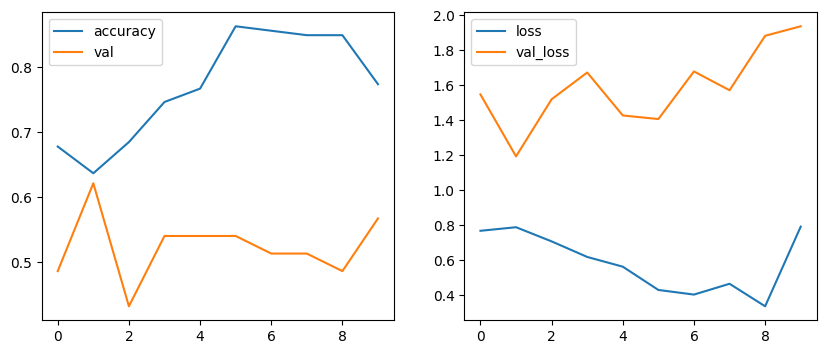

In [112]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].legend(['accuracy', 'val'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].legend(['loss', 'val_loss'], loc='upper left')

plt.show()

In [113]:
def predict(text):
    data = tokenize_sentence(text) 
#     tokenized_data = np.stack(data)
    data = np.array(data).reshape(1,52)
    print(data.shape)
    return f"{text } => "+emoji.emojize( emoji_dictionary[str(np.argmax(model.predict(data))) ] )

    

In [114]:
print(predict(" i love u"))
print(predict("hello i am so happy"))
print(predict(" i am sad"))

(1, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
 i love u => ❤️
(1, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
hello i am so happy => 😁
(1, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
 i am sad => 😓
